In [122]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.model_selection import train_test_split

In [2]:
#local_zip = 'understanding_cloud_organization.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('data/')
#zip_ref.close()

In [3]:
base_dir = ''
train_dir = os.path.join(base_dir, 'train_images')
test_dir = os.path.join(base_dir, 'test_images')

In [4]:
print('total training images:', len(os.listdir(test_dir))) 
print('total testing images:', len(os.listdir(train_dir))) 

total training images: 3698
total testing images: 5546


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as pilimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

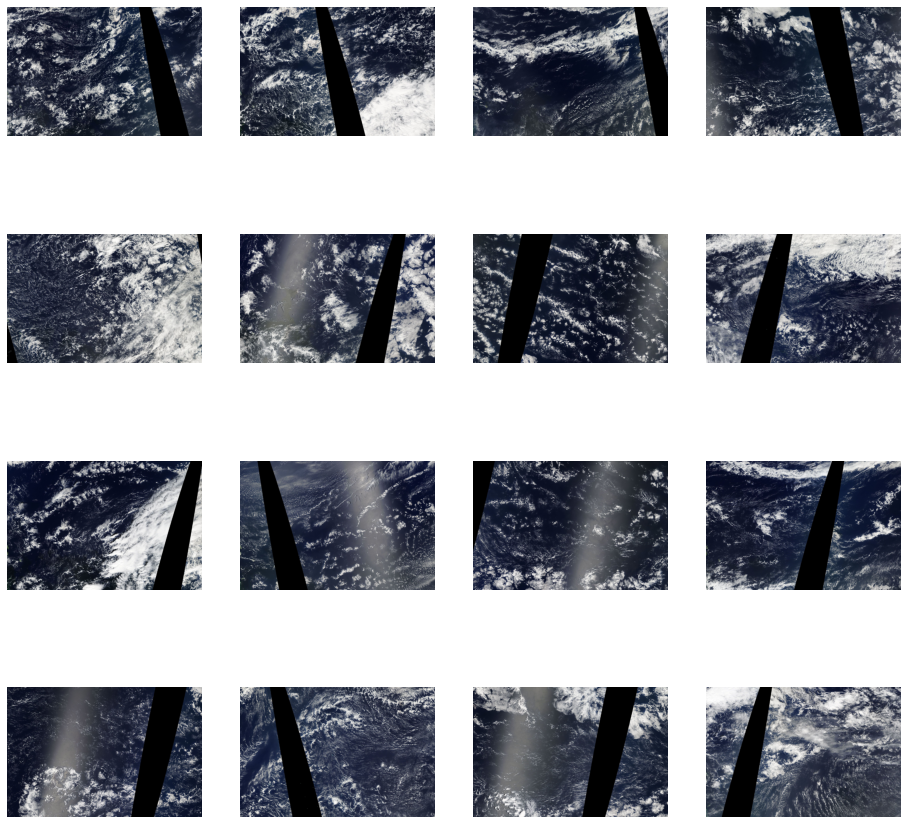

In [6]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_dir_fnames = os.listdir(train_dir)
test_dir_fnames = os.listdir(test_dir)
training_data_arr = [os.path.join(train_dir, fname) 
                for fname in train_dir_fnames]
testing_data_arr = [os.path.join(test_dir, fname) 
                for fname in test_dir_fnames]

for i, img_path in enumerate(training_data_arr):
  # Set up subplot; subplot indices start at 1
  if i == 16:
        break
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
# Makes sure image sizes are all the same

im = pilimg.open("train_images/9156855.jpg")
oldSize = im.size
im.close
print("Image size is:", oldSize)
for i in training_data_arr:
    im = pilimg.open(str(i))
    currSize = im.size
    if oldSize != currSize:
        print("Deviating image size: ", currSize, "and name:", i)
    im.close
print("Tested", len(training_data_arr), "training images")
for i in testing_data_arr:
    im = pilimg.open(str(i))
    currSize = im.size
    if oldSize != currSize:
        print("Deviating image size: ", currSize, "and name:", i)
    im.close
print("Tested", len(testing_data_arr), "testing images")

Image size is: (2100, 1400)
Tested 5546 training images
Tested 3698 testing images


In [8]:
trainDF = pd.read_csv('train.csv')
trainDF['Image_Name'] = trainDF['Image_Label'].apply(lambda x: x.split('_')[0])
trainDF['Label_Name'] = trainDF['Image_Label'].apply(lambda x: x.split('_')[1])
trainDF['Mask'] = ~ trainDF['EncodedPixels'].isna()
trainDF.head()

,Image_Label,EncodedPixels,Image_Name,Label_Name,Mask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [9]:
submissionDF = pd.read_csv('sample_submission.csv')
submissionDF['Image_Name'] = submissionDF['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(submissionDF['Image_Name'].unique(), columns=['Image_Name'])

submissionDF.head()

,Image_Label,EncodedPixels,Image_Name
0,002f507.jpg_Fish,1 1,002f507.jpg
1,002f507.jpg_Flower,1 1,002f507.jpg
2,002f507.jpg_Gravel,1 1,002f507.jpg
3,002f507.jpg_Sugar,1 1,002f507.jpg
4,0035ae9.jpg_Fish,1 1,0035ae9.jpg


In [39]:
labelDF = trainDF.groupby('Image_Name').agg(np.sum).reset_index()
labelDF.sort_values('Mask', ascending=False, inplace=True)
print(labelDF.shape)
#dataframe of all images who have 2 or more masks
twoLabelDF = labelDF[labelDF['Mask'] >= 2]
print(twoLabelDF.shape)
#dataframe of all images who have 3 or more masks
threeLabelDF = labelDF[labelDF['Mask'] >= 3]
print(threeLabelDF.shape)
#dataframe of all images who have all 4 masks
fourLabelDF = labelDF[labelDF['Mask'] >= 4]
print(fourLabelDF.shape)
#we can use these to boost performance of our NN
fourLabelDF.head()

(5546, 2)
(4198, 2)
(1826, 2)
(266, 2)
Image_Name    24dd99c.jpg
Mask                    4
Name: 821, dtype: object


In [11]:
def resizeImage(img, input_shape):
    height, width = input_shape
    newImg = cv2.resize(img, (width, height))
    return newImg

# convert given masks to encoded pixels 
def encodeMask(masks, reshape):
    width, height, category = masks.shape
    encoded = []
    for i in range(category):
        mask = masks[:, :, i]

        mask = np_resize(mask.astype(np.float32), reshape).astype(np.int64)
        #mask = np_resize(mask, reshape)
        
        pixels= mask.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        
        encoded.append(' '.join(str(x) for x in runs))
        
    return encoded

# convert encoded pixels 5(start) 100(pixels after) to a image mask of 1 and 0
def createMask(pixelArr, shape, reshape):
    masks = np.zeros((*reshape, len(pixelArr)))
    
    for i, encoded in enumerate(pixelArr):
        width, height = shape[:2] 
        if type(encoded) is str:
            mask = np.zeros(width*height).astype(np.uint8)

            array = np.asarray([int(x) for x in encoded.split()])
            startPixel = array[0::2]
            runOnPixels = array[1::2]
            
            for j, runOn in enumerate(startPixel):
                mask[int(startPixel[j]): int(startPixel[j]) + int(runOnPixels[j])] = 1
            mask = mask.reshape(height, width).T
            masks[:, :, i] = resizeImage(mask, reshape)
    
    return masks 

In [126]:
# https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels_df, generate_df, image_path,
                 to_fit=True, batch_size=20, dim=(1400, 2100),
                 n_channels=1, n_classes=4, shuffle=True, output_dim = (350, 525)):
        """Initialization

        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels_df = labels_df
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.output_dim = output_dim
        self.generate_df = generate_df

    def __len__(self):
        """Denotes the number of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images

        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.output_dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            gimage = self._load_grayscale_image(self.image_path + '/' + self.labels_df['Image_Name'].iloc[ID])
            gimage = resizeImage(gimage, self.output_dim)
            gimage = np.expand_dims(gimage, axis=-1)
            X[i,] = gimage

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks

        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.output_dim, self.n_classes), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            mask_df = self.generate_df[self.generate_df['Image_Name'] == self.labels_df['Image_Name'].iloc[ID]]
            
            encodedPix = mask_df['EncodedPixels'].values
            onlyMask = createMask(encodedPix, self.dim, self.output_dim)
            y[i,] = onlyMask

        return y

    def _load_grayscale_image(self, image_path):
        """Load grayscale image

        :param image_path: path to image to load
        :return: loaded image
        """
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255
        img = np.expand_dims(img, axis=-1)
        return img
    
base_dir = ''
train_dir = os.path.join(base_dir, 'train_images')
test_dir = os.path.join(base_dir, 'test_images')

trainImages, validationImages = train_test_split(
    fourLabelDF.index, test_size=0.2
)

print(len(trainImages))
print(len(validationImages))

train_generator = DataGenerator(
    trainImages, 
    labels_df=labelDF,
    generate_df=trainDF,
    image_path = train_dir,
    output_dim = (320, 480)
)

validation_generator = DataGenerator(
    trainImages, 
    labels_df=labelDF,
    generate_df=trainDF,
    to_fit=True,
    image_path = train_dir,
    output_dim = (320, 480)
)

212
54


In [127]:
inputs = Input([320, 480, 1])

c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
p1 = MaxPooling2D((2, 2), padding='same') (c1)

c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
p2 = MaxPooling2D((2, 2), padding='same') (c2)

c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
p3 = MaxPooling2D((2, 2), padding='same') (c3)

c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
p4 = MaxPooling2D((2, 2), padding='same') (c4)

c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
p5 = MaxPooling2D((2, 2), padding='same') (c5)

c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
conv2d_529 (Conv2D)             (None, 320, 480, 8)  80          input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_530 (Conv2D)             (None, 320, 480, 8)  584         conv2d_529[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_114 (MaxPooling2D (None, 160, 240, 8)  0           conv2d_530[0][0]                 
___________________________________________________________________________________________

In [128]:
# https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [129]:
model.compile(loss = bce_dice_loss,
              optimizer = Adam(lr = 0.002),
              metrics = [dice_coef])

In [ ]:
history = model.fit_generator(
      train_generator,
      epochs = 100,
      validation_data = validation_generator,
      verbose = 2)

Epoch 1/100
 - 134s - loss: 1.4171 - dice_coef: 0.2252 - val_loss: 1.3426 - val_dice_coef: 0.2105
Epoch 2/100
 - 126s - loss: 1.3093 - dice_coef: 0.1915 - val_loss: 1.3078 - val_dice_coef: 0.1744
Epoch 3/100
 - 125s - loss: 1.7916 - dice_coef: 0.1795 - val_loss: 1.2887 - val_dice_coef: 0.1797
Epoch 4/100


In [ ]:
model.save('my_model.h5')
model = load_model('my_model.h5', custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})